In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-signs-preprocessed/mean_image_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/data5.pickle
/kaggle/input/traffic-signs-preprocessed/data4.pickle
/kaggle/input/traffic-signs-preprocessed/data7.pickle
/kaggle/input/traffic-signs-preprocessed/data8.pickle
/kaggle/input/traffic-signs-preprocessed/data1.pickle
/kaggle/input/traffic-signs-preprocessed/data3.pickle
/kaggle/input/traffic-signs-preprocessed/test.pickle
/kaggle/input/traffic-signs-preprocessed/mean_image_gray.pickle
/kaggle/input/traffic-signs-preprocessed/data6.pickle
/kaggle/input/traffic-signs-preprocessed/data0.pickle
/kaggle/input/traffic-signs-preprocessed/valid.pickle
/kaggle/input/traffic-signs-preprocessed/data2.pickle
/kaggle/input/traffic-signs-preprocessed/labels.pickle
/kaggle/input/traffic-signs-preprocessed/datasets_preparing.py
/kaggle/input/traffic-signs-preprocessed/std_gray.pickle
/kaggle/input/traffic-signs-preprocessed/std_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/label_na

In [4]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('../input'))

../input/traffic-signs-preprocessed/mean_image_rgb.pickle
../input/traffic-signs-preprocessed/data5.pickle
../input/traffic-signs-preprocessed/data4.pickle
../input/traffic-signs-preprocessed/data7.pickle
../input/traffic-signs-preprocessed/data8.pickle
../input/traffic-signs-preprocessed/data1.pickle
../input/traffic-signs-preprocessed/data3.pickle
../input/traffic-signs-preprocessed/test.pickle
../input/traffic-signs-preprocessed/mean_image_gray.pickle
../input/traffic-signs-preprocessed/data6.pickle
../input/traffic-signs-preprocessed/data0.pickle
../input/traffic-signs-preprocessed/valid.pickle
../input/traffic-signs-preprocessed/data2.pickle
../input/traffic-signs-preprocessed/labels.pickle
../input/traffic-signs-preprocessed/datasets_preparing.py
../input/traffic-signs-preprocessed/std_gray.pickle
../input/traffic-signs-preprocessed/std_rgb.pickle
../input/traffic-signs-preprocessed/label_names.csv
../input/traffic-signs-preprocessed/train.pickle
['traffic-signs-preprocessed']


In [5]:
with open('../input/traffic-signs-preprocessed/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


(81, 32, 32, 3)


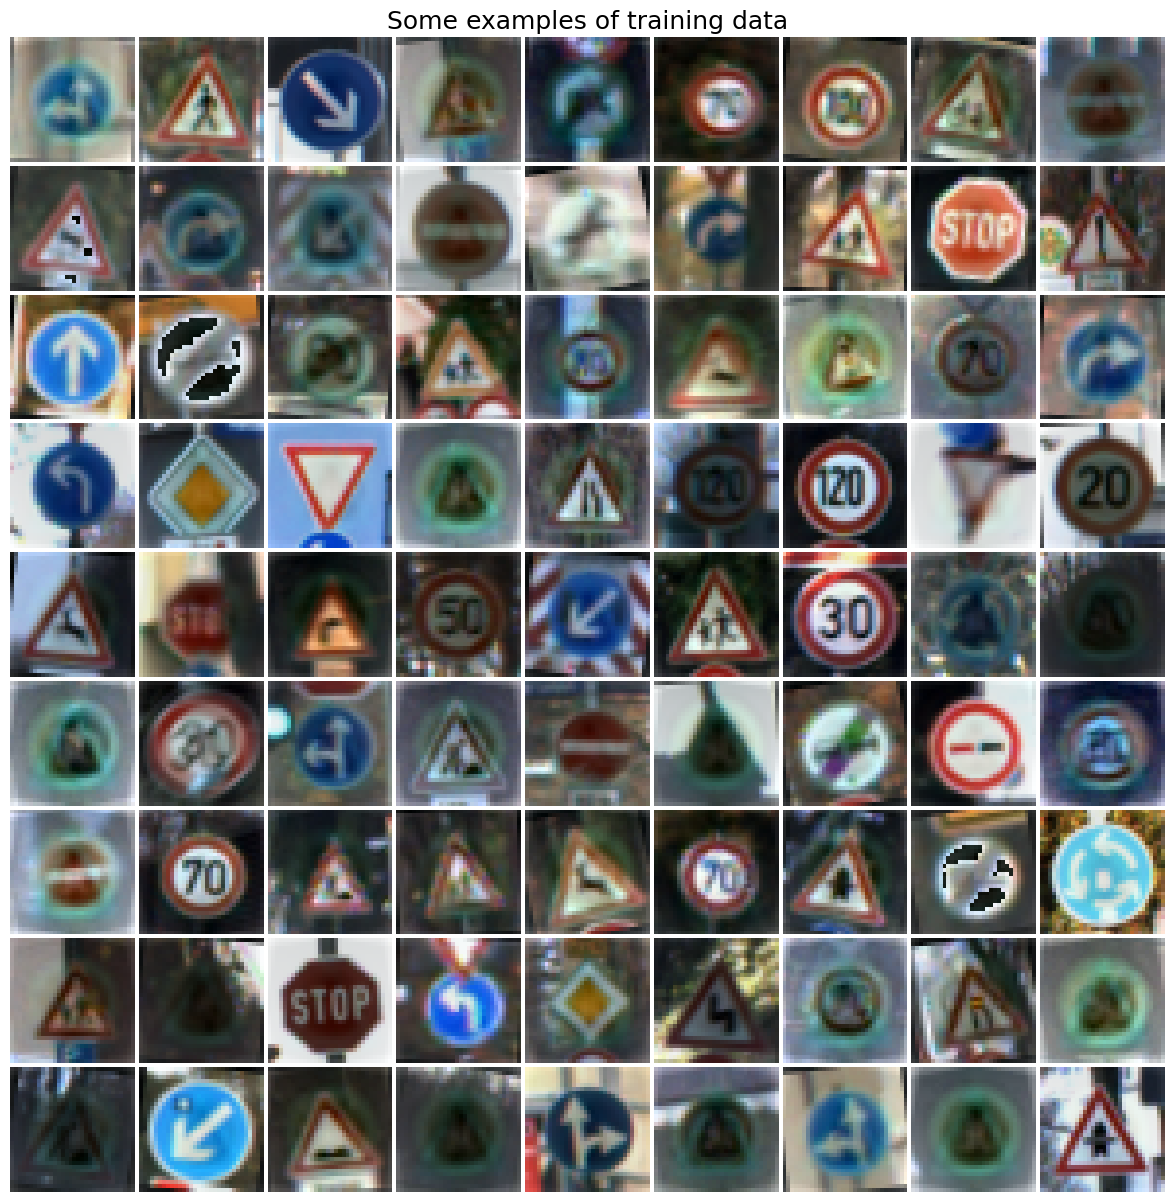

In [11]:
%matplotlib inline

def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
            next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 15

h = model.fit(data['x_train'][:10], data['y_train'][:10],
              batch_size=5, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)

Epoch 1/15
2/2 [==============================] - 7s 6s/step - loss: 3.7781 - accuracy: 0.0000e+00 - val_loss: 3.8243 - val_accuracy: 0.0229 - lr: 4.6329e-04
Epoch 2/15
2/2 [==============================] - 5s 5s/step - loss: 2.8446 - accuracy: 0.4000 - val_loss: 4.0208 - val_accuracy: 0.0324 - lr: 4.4013e-04
Epoch 3/15
2/2 [==============================] - 10s 10s/step - loss: 2.1845 - accuracy: 0.5000 - val_loss: 4.4171 - val_accuracy: 0.0347 - lr: 4.1812e-04
Epoch 4/15
2/2 [==============================] - 5s 5s/step - loss: 1.7447 - accuracy: 0.4000 - val_loss: 5.0155 - val_accuracy: 0.0367 - lr: 3.9721e-04
Epoch 5/15
2/2 [==============================] - 5s 5s/step - loss: 1.4620 - accuracy: 0.5000 - val_loss: 5.6172 - val_accuracy: 0.0379 - lr: 3.7735e-04
Epoch 6/15
2/2 [==============================] - 5s 5s/step - loss: 1.2322 - accuracy: 0.6000 - val_loss: 6.1889 - val_accuracy: 0.0381 - lr: 3.5849e-04
Epoch 7/15
2/2 [==============================] - 5s 5s/step - loss: 1

In [16]:
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))

Epochs=15, training accuracy=1.00000, validation accuracy=0.04558


In [17]:
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]
model = [0] * len(filters)

for i in range(len(model)):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=filters[i], padding='same', activation='relu', input_shape=(32, 32, 3)))
    model[i].add(MaxPool2D(pool_size=2))
    model[i].add(Flatten())
    model[i].add(Dense(500, activation='relu'))
    model[i].add(Dense(43, activation='softmax'))
    model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 5

h = [0] * len(model)

for i in range(len(h)):
    h[i] = model[i].fit(data['x_train'], data['y_train'],
                        batch_size=5, epochs = epochs,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=0)
    
    print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation accuracy={3:.5f}'.\
      format(filters[i], epochs, max(h[i].history['accuracy']), max(h[i].history['val_acc'])))

In [19]:
for i in range(len(model)):
    temp = model[i].predict(data['x_test'])
    temp = np.argmax(temp, axis=1)

    # We compare predicted class with correct class for all input images
    # And calculating mean value among all values of following numpy array
    # By saying 'testing_accuracy == data['y_test']' we create numpy array with True and False values
    # 'np.mean' function will return average of the array elements
    # The average is taken over the flattened array by default
    temp = np.mean(temp == data['y_test'])
    
    print('data2 filter {0:d} testing accuracy = {1:.5f}'.format(filters[i], temp))

395/395 [==============================] - 4s 10ms/step
data2 filter 3 testing accuracy = 0.86912
395/395 [==============================] - 5s 12ms/step
data2 filter 5 testing accuracy = 0.02660
395/395 [==============================] - 7s 17ms/step
data2 filter 9 testing accuracy = 0.02225
395/395 [==============================] - 11s 27ms/step
data2 filter 13 testing accuracy = 0.02288
395/395 [==============================] - 14s 35ms/step
data2 filter 15 testing accuracy = 0.01235
395/395 [==============================] - 22s 54ms/step
data2 filter 19 testing accuracy = 0.01584
395/395 [==============================] - 31s 77ms/step
data2 filter 23 testing accuracy = 0.01481
395/395 [==============================] - 37s 93ms/step
data2 filter 25 testing accuracy = 0.01394
395/395 [==============================] - 58s 147ms/step
data2 filter 31 testing accuracy = 0.02138


In [20]:
for i in range(len(model)):
    start = timer()
    temp = model[i].predict(data['x_test'][:1, :, :, :])
    end = timer()
    
    print('data2 filter {0:d} classification time = {1:.5f}'.format(filters[i], end - start))

1/1 [==============================] - 0s 30ms/step
data2 filter 3 classification time = 0.08824
1/1 [==============================] - 0s 26ms/step
data2 filter 5 classification time = 0.07285
1/1 [==============================] - 0s 31ms/step
data2 filter 9 classification time = 0.11901
1/1 [==============================] - 0s 28ms/step
data2 filter 13 classification time = 0.08196
1/1 [==============================] - 0s 31ms/step
data2 filter 15 classification time = 0.07672
1/1 [==============================] - 0s 32ms/step
data2 filter 19 classification time = 0.08277
1/1 [==============================] - 0s 27ms/step
data2 filter 23 classification time = 0.07642
1/1 [==============================] - 0s 29ms/step
data2 filter 25 classification time = 0.07566
1/1 [==============================] - 0s 34ms/step
data2 filter 31 classification time = 0.07593


(1, 32, 32, 3)
[3]


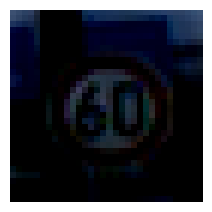

1/1 [==============================] - 0s 42ms/step
(43,)
ClassId: 3
Label: Speed limit (60km/h)


In [21]:
%matplotlib inline

# Preparing image for predicting from test dataset
x_input = data['x_test'][100:101]
print(x_input.shape)
y_input = data['y_test'][100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

plt.show()

# Getting scores from forward pass of input image
scores = model[0].predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list

labels = label_text('../input/traffic-signs-preprocessed/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])

In [22]:
for i in range(len(model)):
    name = 'model-' + str(filters[i]) + 'x' + str(filters[i]) + '.h5'
    model[i].save(name)